# Code to test before run on hpcc

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#matplotlib graphs will be included in your notebook, next to the code:
%matplotlib inline

# Neural networks
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

import torchvision

import h5py
import os

from H5Dataset import H5Dataset
from CNNModels import *
from CNNTrain import *

In [2]:
np.random.seed(0)  # set seed for reproduceability
test_number = 2  # set number for snapshot indexing
epoch0 = 20  # number of epoch to run for first model
epoch1 = 5  # number of epoch to run for second model
epoch2 = 1  # number of epoch to run for third model 

In [3]:
hdf5_dir = "/mnt/scratch/tranant2/2022_11_21_data"  # path to data
main_dir = "/mnt/home/tranant2/Desktop/MachineLearning/TRACK/CNN9"
files = os.listdir(hdf5_dir)
hdf5_files1 = [(hdf5_dir + '/'+i) for i in files ]  # create list of paths for all data files

In [4]:
# print data path for reference
for file in hdf5_files1:
    print(file)

/mnt/scratch/tranant2/2022_11_21_data/data_0.hdf5
/mnt/scratch/tranant2/2022_11_21_data/data_2.hdf5
/mnt/scratch/tranant2/2022_11_21_data/data_3.hdf5
/mnt/scratch/tranant2/2022_11_21_data/data_1.hdf5


In [5]:
dataset = H5Dataset(hdf5_files1[0:4], transform=False)  # Go through each file separately and add to dataset

20
(20, 33, 33, 6)
Added first file, current memory of dataset: 0.002406537818020143
20
(20, 33, 33, 6)
Added another file, current memory of dataset: 0.004813075636040286
20
(20, 33, 33, 6)
Added another file, current memory of dataset: 0.0072196134540604305
20
(20, 33, 33, 6)
Added another file, current memory of dataset: 0.009626151272080573


In [6]:
# separate training and test dataset
ntrain = int(dataset.__len__()*.8)
ntest = dataset.__len__() - ntrain

In [7]:
# add dataset to torch DataLoader. This allow a simple way to shuffle the data and to change the batch size
train_set, test_set = torch.utils.data.random_split(dataset,[ntrain,ntest])
train_loader = DataLoader(dataset=train_set, batch_size = 1024, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size = 1024, shuffle=True)

### Make sure GPU is avaliable

In [8]:
print(f"Is GPU avaliable: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Got the: {torch.cuda.get_device_name(0)}")
    print(f"Total memory: {torch.cuda.get_device_properties(0).total_memory/(1028**3)} GB")

Is GPU avaliable: True
Got the: Tesla K80
Total memory: 11.781983108519892 GB


In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Computation will be happening on the {device}")

Computation will be happening on the cuda:0


## Train 1

In [10]:
learning_rate = 0.001

model = VAE().to(device)

In [11]:
# Code to get params and list which parameters we want to freeze
# Note only the parameters related to the loss predictor are frozen
params = model.state_dict()
keys = list(params.keys())
for key in keys[-6:]:
    print(key)

Loss0.weight
Loss0.bias
Loss1.weight
Loss1.bias
Loss2.weight
Loss2.bias


In [12]:
# Code to remove require grad, effectively freezing these layers
for name, param in model.named_parameters():
    if name in keys[-6:] and param.requires_grad:
        param.requires_grad = False

In [13]:
# After we note which param should require grad, we then only let the optimizer update the parameters with required grad.
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.to(device).parameters()), lr=learning_rate,
                       betas=(.950,.970),
                       eps=1e-9,
                       weight_decay = 0.001,
                       amsgrad=False,)

In [14]:
n_epochs = epoch0
train_losses, counter = train_model(model, n_epochs, train_loader, optimizer, device = device)  # train the model

Train Epoch: 0 [0/64 (0%)]	Loss: 4145.319336
loss0:0,loss1:0, loss2:0, loss3:0,
 distro0:1585.5277099609375, distro1:1324.1075439453125, distro2:773.46923828125, distro3:337.0494384765625, distro4:125.16570281982422
Train Epoch: 1 [0/64 (0%)]	Loss: 4072.086182
loss0:0,loss1:0, loss2:0, loss3:0,
 distro0:1532.62841796875, distro1:1309.1123046875, distro2:768.9485473632812, distro3:336.33050537109375, distro4:125.06647491455078
Train Epoch: 2 [0/64 (0%)]	Loss: 3922.223633
loss0:0,loss1:0, loss2:0, loss3:0,
 distro0:1457.4456787109375, distro1:1260.7784423828125, distro2:748.9732055664062, distro3:331.0550231933594, distro4:123.97134399414062
Train Epoch: 3 [0/64 (0%)]	Loss: 3819.378906
loss0:0,loss1:0, loss2:0, loss3:0,
 distro0:1441.6572265625, distro1:1210.1419677734375, distro2:723.9552001953125, distro3:321.9018859863281, distro4:121.72266387939453
Train Epoch: 4 [0/64 (0%)]	Loss: 3591.790771
loss0:0,loss1:0, loss2:0, loss3:0,
 distro0:1246.4256591796875, distro1:1188.523681640625, d

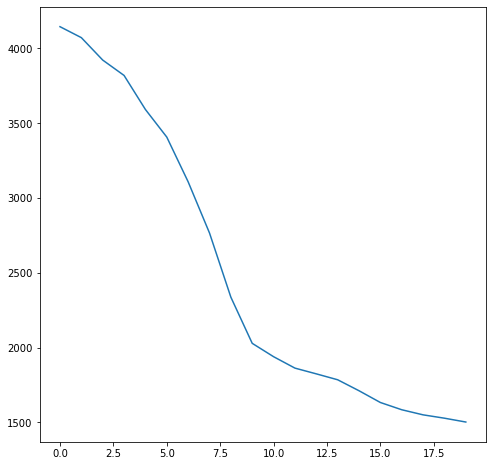

In [15]:
fig, ax = plt.subplots(1,1,figsize=(8, 8))  # a figure with a single Axes
plt.plot(train_losses)
fig.savefig(f"{main_dir}/loss_{test_number}.png", dpi = 100)

In [16]:
examples = enumerate(test_loader)
batch_idx, (test_data, test_targets) = next(examples)

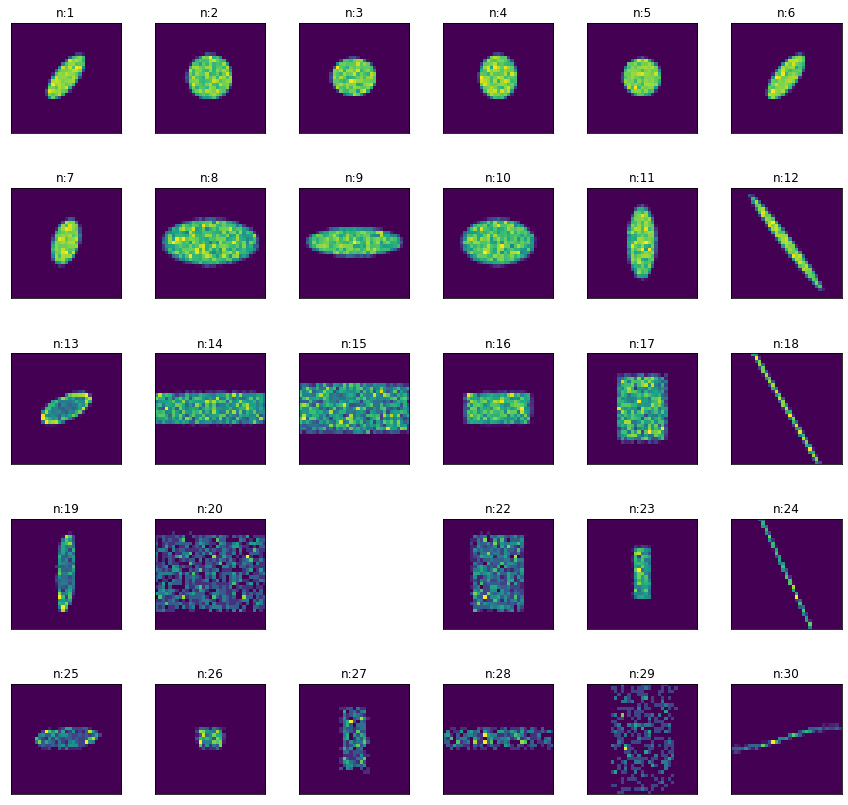

In [17]:
fig = plt.figure(figsize=(12,12))
nimg = 2
for j in range(5):
    for i in range(6):
        plt.subplot(5,6,i+1+j*6)
        plt.tight_layout()
        plt.imshow(np.array(test_data[j+1])[nimg,:,:,i], cmap='viridis', interpolation='none')
        plt.title(f"n:{i+1+j*6}")
        plt.xticks([])
        plt.yticks([])
fig.savefig(f"{main_dir}/OriginalPhaseSpace_{test_number}.png", dpi = 100)

loss0:0,loss1:0, loss2:0, loss3:0,
 distro0:223.27081298828125, distro1:394.5698547363281, distro2:390.3197937011719, distro3:198.8833465576172, distro4:53.00820541381836


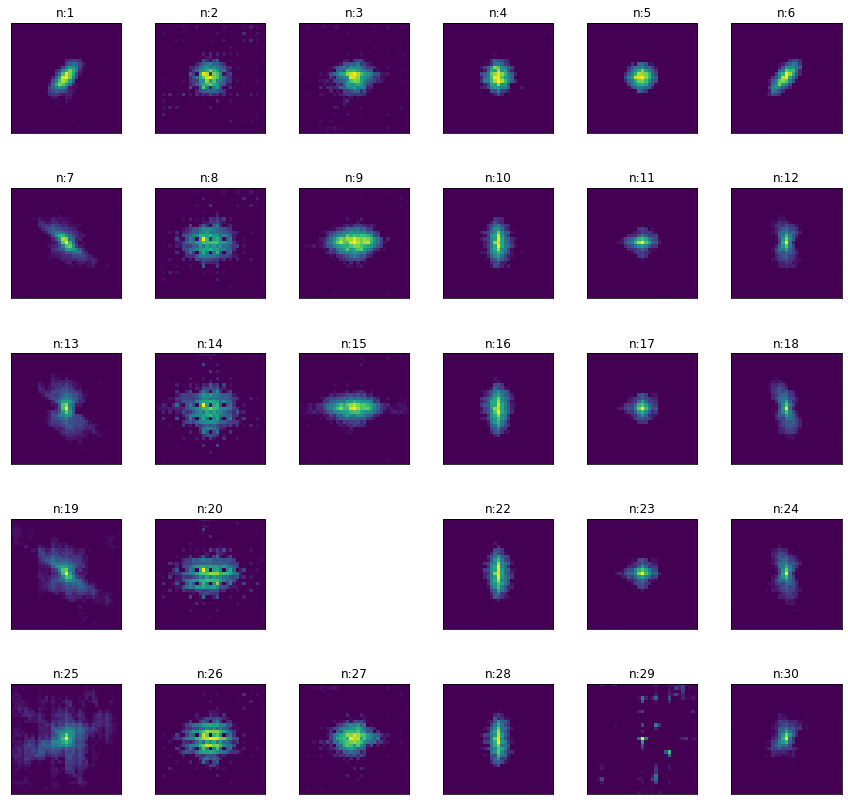

In [18]:
voltages = test_data[0].to(device)
distro_0 = test_data[1].to(device)
distro_1 = test_data[2].to(device)
distro_2 = test_data[3].to(device)
distro_3 = test_data[4].to(device)
distro_4 = test_data[5].to(device)
output_0 = test_targets[0].to(device)
output_1 = test_targets[1].to(device)
output_2 = test_targets[2].to(device)
output_3 = test_targets[3].to(device)
with torch.no_grad():
    distro, losses = model(voltages=voltages,
                           distro0=distro_0,
                           distro1=distro_1,
                           distro2=distro_2,
                           distro3=distro_3,
                           distro4=distro_4,
                           output0=output_0,
                           output1=output_1,
                           output2=output_2,
                           output3=output_3)
loss4 = nn.MSELoss()(distro_0, distro[0])
loss5 = nn.MSELoss()(distro_1, distro[1])
loss6 = nn.MSELoss()(distro_2, distro[2])
loss7 = nn.MSELoss()(distro_3, distro[3])
loss8 = nn.MSELoss()(distro_4, distro[4])
print(f"loss0:{0},loss1:{0}, loss2:{0}, loss3:{0},\n distro0:{loss4}, distro1:{loss5}, distro2:{loss6}, distro3:{loss7}, distro4:{loss8}")
    
fig = plt.figure(figsize=(12,12))
nimg = 2
for j in range(5):
    for i in range(6):
        plt.subplot(5,6,i+1+j*6)
        plt.tight_layout()
        plt.imshow(np.array(distro[j].cpu())[nimg,:,:,i], cmap='viridis', interpolation='none')
        plt.title(f"n:{i+1+j*6}")
        plt.xticks([])
        plt.yticks([])
fig.savefig(f"{main_dir}/ReconstructedPhaseSpace_{test_number}.png", dpi = 100)

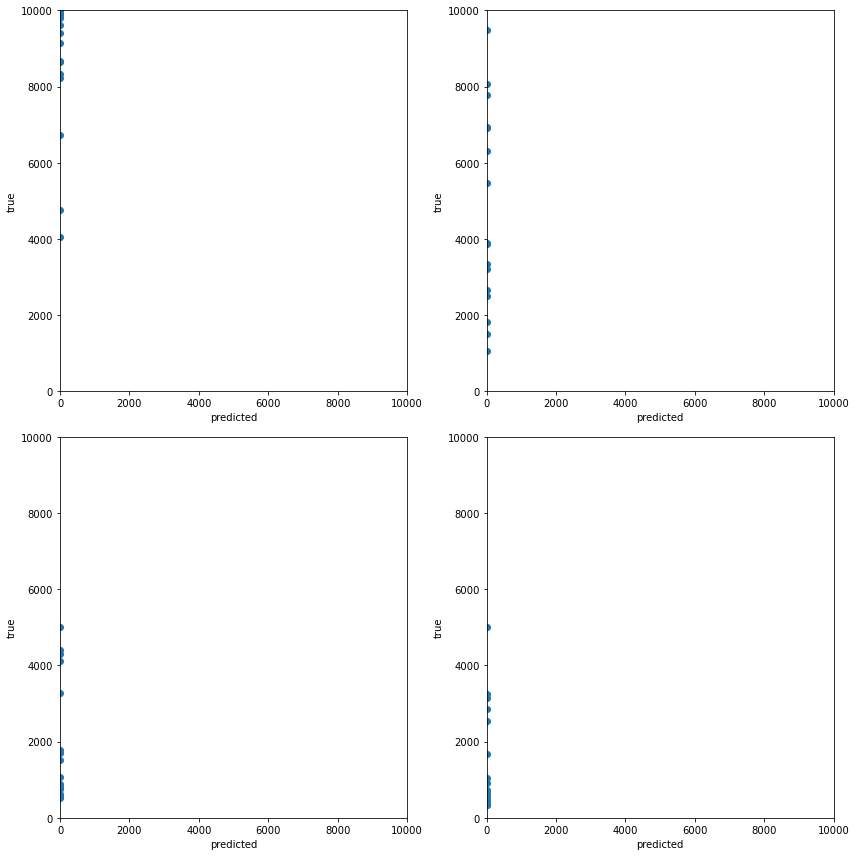

In [19]:
fig = plt.figure(figsize=(12,12))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.tight_layout()
    plt.scatter(losses[i].cpu(),test_targets[i])
    plt.xlabel('predicted')
    plt.ylabel('true')
    plt.xlim(0,10000)
    plt.ylim(0,10000)
fig.savefig(f"{main_dir}/Losses_{test_number}.png", dpi = 100)

In [20]:
# Here I save the model parameters. That way, we can use the parameters for the next training precedure.
torch.save(model.state_dict(), f"{main_dir}/model_{test_number}.pth")

This is the end of the first round of training. The model was trained on all the data and then it's parameters were saved. It will then be uploaded in the next training set. When training with all the data points, saving the model parameters to the disk is important since the current GPU is not able to run the first training procedure and then the second one without crashing from a low memory error. 

## Train 2

In [42]:
print("On to stage 2 of training. Training the loss evaluator...")

On to stage 2 of training. Training the loss function...


In [22]:
model.load_state_dict(torch.load( f"{main_dir}/model_{test_number}.pth"), strict=False)

<All keys matched successfully>

In [23]:
# Code to get params
# Note now, we only train the model parameters related to the loss evaluator.
params = model.state_dict()
keys = list(params.keys())
for key in keys[:-6]:
    print(key)

encoders.0.c2d1.weight
encoders.0.c2d1.bias
encoders.0.c2d2.weight
encoders.0.c2d2.bias
encoders.0.linear1.weight
encoders.0.linear1.bias
encoders.1.c2d1.weight
encoders.1.c2d1.bias
encoders.1.c2d2.weight
encoders.1.c2d2.bias
encoders.1.linear1.weight
encoders.1.linear1.bias
encoders.2.c2d1.weight
encoders.2.c2d1.bias
encoders.2.c2d2.weight
encoders.2.c2d2.bias
encoders.2.linear1.weight
encoders.2.linear1.bias
encoders.3.c2d1.weight
encoders.3.c2d1.bias
encoders.3.c2d2.weight
encoders.3.c2d2.bias
encoders.3.linear1.weight
encoders.3.linear1.bias
encoders.4.c2d1.weight
encoders.4.c2d1.bias
encoders.4.c2d2.weight
encoders.4.c2d2.bias
encoders.4.linear1.weight
encoders.4.linear1.bias
encoders.5.c2d1.weight
encoders.5.c2d1.bias
encoders.5.c2d2.weight
encoders.5.c2d2.bias
encoders.5.linear1.weight
encoders.5.linear1.bias
decoders.0.linear2.weight
decoders.0.linear2.bias
decoders.0.ct2d1.weight
decoders.0.ct2d1.bias
decoders.0.ct2d2.weight
decoders.0.ct2d2.bias
decoders.0.ct2d3.weight
decode

In [24]:
# Code add back gradient
for name, param in model.named_parameters():
    if not param.requires_grad:
        param.requires_grad = True
        
# Code to remove remove gradient from auto-encoder
for name, param in model.named_parameters():
    if name in keys[:-6] and param.requires_grad:
        param.requires_grad = False

In [25]:
optimizer2 = optim.Adam(filter(lambda p: p.requires_grad, model.to(device).parameters()), lr=.01,
                       betas=(.950,.970),
                       eps=1e-9,
                       weight_decay = 0.000,
                       amsgrad=False,)

In [26]:
n_epochs = epoch1  # we train this for a different number of epoch
train_losses, counter = train_model2(model, n_epochs, train_loader, optimizer2, device=device)

Train Epoch: 0 [0/64 (0%)]	Loss: 18918.470703
loss0:8458.3203125,loss1:5228.494140625, loss2:2990.546875, loss3:2241.109375
Train Epoch: 1 [0/64 (0%)]	Loss: 17283.679688
loss0:7667.39453125,loss1:4652.888671875, loss2:2797.13671875, loss3:2166.2587890625
Train Epoch: 2 [0/64 (0%)]	Loss: 12833.287109
loss0:5484.71875,loss1:3149.28125, loss2:2274.7109375, loss3:1924.576171875
Train Epoch: 3 [0/64 (0%)]	Loss: 6850.136719
loss0:1468.28125,loss1:1959.0625, loss2:1879.9921875, loss3:1542.80078125
Train Epoch: 4 [0/64 (0%)]	Loss: 16392.851562
loss0:7133.0,loss1:5437.375, loss2:2337.421875, loss3:1485.0546875


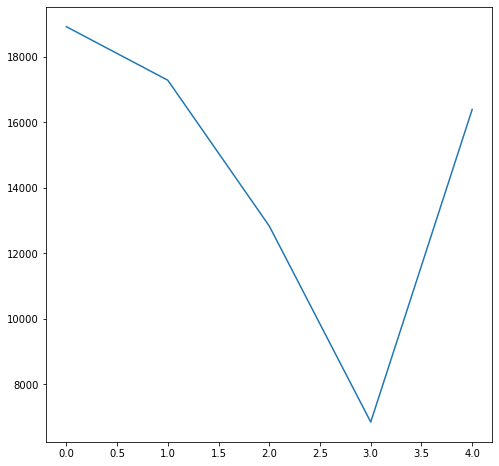

In [27]:
fig, ax = plt.subplots(1,1,figsize=(8, 8))  # a figure with a single Axes
plt.plot(train_losses)
fig.savefig(f"{main_dir}/loss_{test_number}_2.png", dpi = 100)

In [28]:
examples = enumerate(test_loader)
batch_idx, (test_data, test_targets) = next(examples)

loss0:40081.625,loss1:32053.55859375, loss2:16383.49609375, loss3:9684.8212890625,
 distro0:0, distro1:0, distro2:0, distro3:0, distro4:0


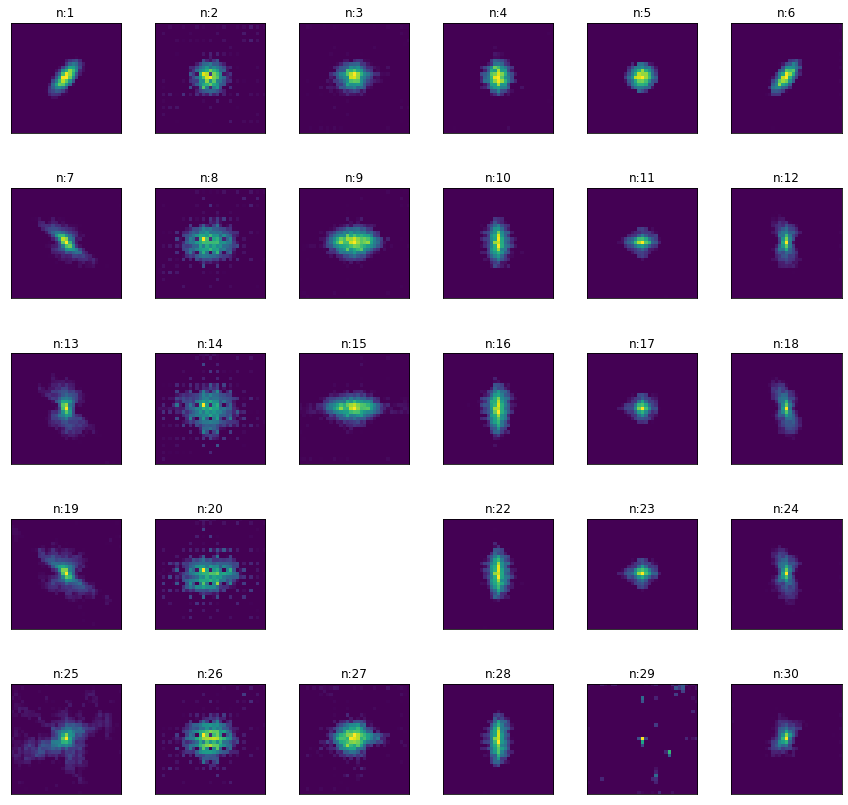

In [29]:
voltages = test_data[0].to(device)
distro_0 = test_data[1].to(device)
distro_1 = test_data[2].to(device)
distro_2 = test_data[3].to(device)
distro_3 = test_data[4].to(device)
distro_4 = test_data[5].to(device)
output_0 = test_targets[0].to(device)
output_1 = test_targets[1].to(device)
output_2 = test_targets[2].to(device)
output_3 = test_targets[3].to(device)
with torch.no_grad():
    distro, losses = model(voltages=voltages,
                           distro0=distro_0,
                           distro1=distro_1,
                           distro2=distro_2,
                           distro3=distro_3,
                           distro4=distro_4,
                           output0=output_0,
                           output1=output_1,
                           output2=output_2,
                           output3=output_3)
loss0 = nn.HuberLoss(reduction='mean', delta=10.0)(output_0, losses[0])
loss1 = nn.HuberLoss(reduction='mean', delta=10.0)(output_1, losses[1])
loss2 = nn.HuberLoss(reduction='mean', delta=10.0)(output_2, losses[2])
loss3 = nn.HuberLoss(reduction='mean', delta=10.0)(output_3, losses[3])
print(f"loss0:{loss0},loss1:{loss1}, loss2:{loss2}, loss3:{loss3},\n distro0:{0}, distro1:{0}, distro2:{0}, distro3:{0}, distro4:{0}")
    
fig = plt.figure(figsize=(12,12))
nimg = 2
for j in range(5):
    for i in range(6):
        plt.subplot(5,6,i+1+j*6)
        plt.tight_layout()
        plt.imshow(np.array(distro[j].cpu())[nimg,:,:,i], cmap='viridis', interpolation='none')
        plt.title(f"n:{i+1+j*6}")
        plt.xticks([])
        plt.yticks([])
fig.savefig(f"{main_dir}/ReconstructedPhaseSpace_{test_number}_2.png", dpi = 100)

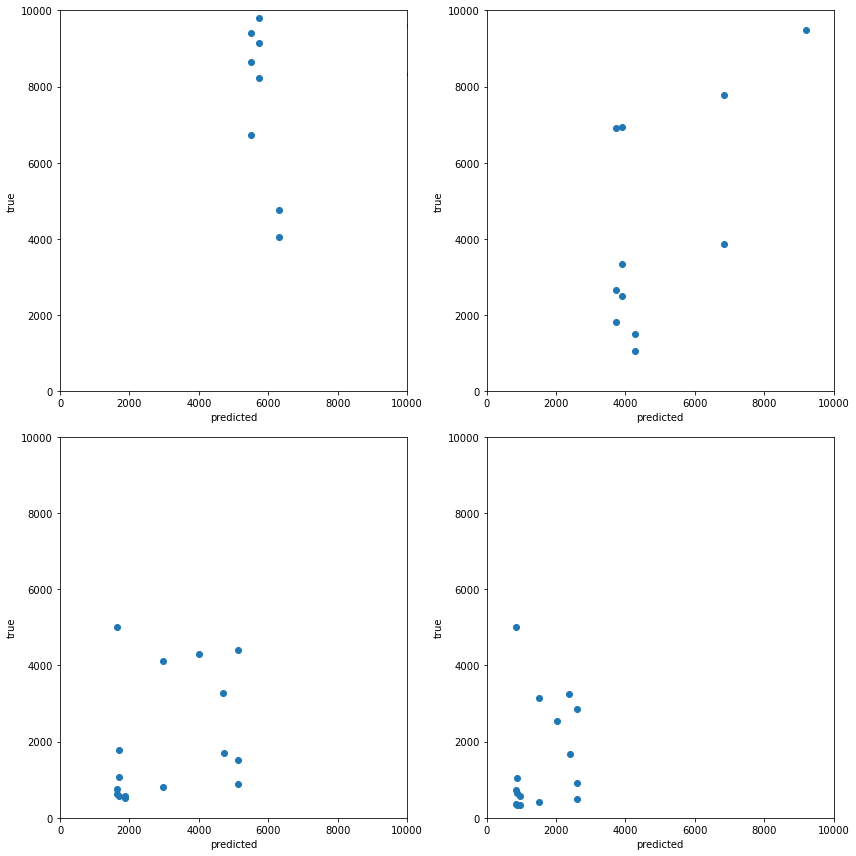

In [30]:
fig = plt.figure(figsize=(12,12))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.tight_layout()
    plt.scatter(losses[i].cpu(),test_targets[i])
    plt.xlabel('predicted')
    plt.ylabel('true')
    plt.xlim(0,10000)
    plt.ylim(0,10000)
fig.savefig(f"{main_dir}/Losses_{test_number}_2.png", dpi = 100)

In [31]:
torch.save(model.state_dict(), f"{main_dir}/model__{test_number}.pth")

We see that the loss prediction is a bit better. This ends the 2nd training set.
Next the training 3. Here we unfreeze everything and train with a lower learning rate in order to fine tune the model.

## Train 3

In [32]:
print("Finally, on to training 3: To fine tune the model. Make sure no overtraining")

Finally, on to training 3: To fine tune things. Makue sure no overtraining


In [33]:
model.load_state_dict(torch.load( f"{main_dir}/model_{test_number}.pth"), strict=False)

<All keys matched successfully>

In [34]:
# Code add back gradient
for name, param in model.named_parameters():
    if not param.requires_grad:
        param.requires_grad = True

In [35]:
optimizer3 = optim.Adam(filter(lambda p: p.requires_grad, model.to(device).parameters()), lr=0.001,
                       betas=(.950,.970),
                       eps=1e-9,
                       weight_decay = 0.000,
                       amsgrad=False,)

In [36]:
n_epochs = epoch2
train_losses, counter = train_model3(model, n_epochs, train_loader, optimizer3, device=device)

Train Epoch: 0 [0/64 (0%)]	Loss: 20390.621094
loss0:8458.3203125,loss1:5228.494140625, loss2:2990.546875, loss3:2241.109375,
 distro0:168.11337280273438, distro1:484.3080139160156, distro2:451.82989501953125, distro3:259.4154052734375, distro4:108.4832763671875


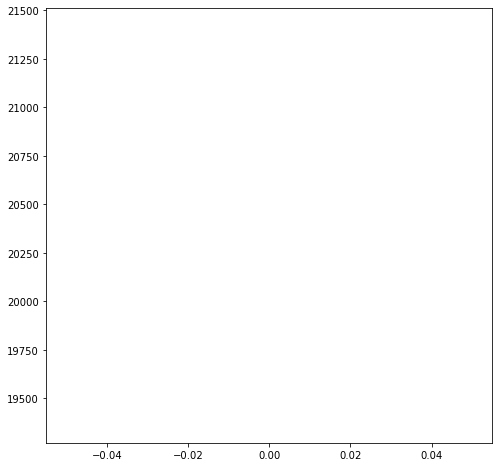

In [37]:
fig, ax = plt.subplots(1,1,figsize=(8, 8))  # a figure with a single Axes
plt.plot(train_losses)
fig.savefig(f"{main_dir}/loss_{test_number}_3.png", dpi = 100)

In [38]:
examples = enumerate(test_loader)
batch_idx, (test_data, test_targets) = next(examples)

loss0:85092.7265625,loss1:46285.5, loss2:19780.1953125, loss3:15104.5029296875,
 distro0:437.98583984375, distro1:458.6121826171875, distro2:390.1079406738281, distro3:204.7640838623047, distro4:53.543827056884766


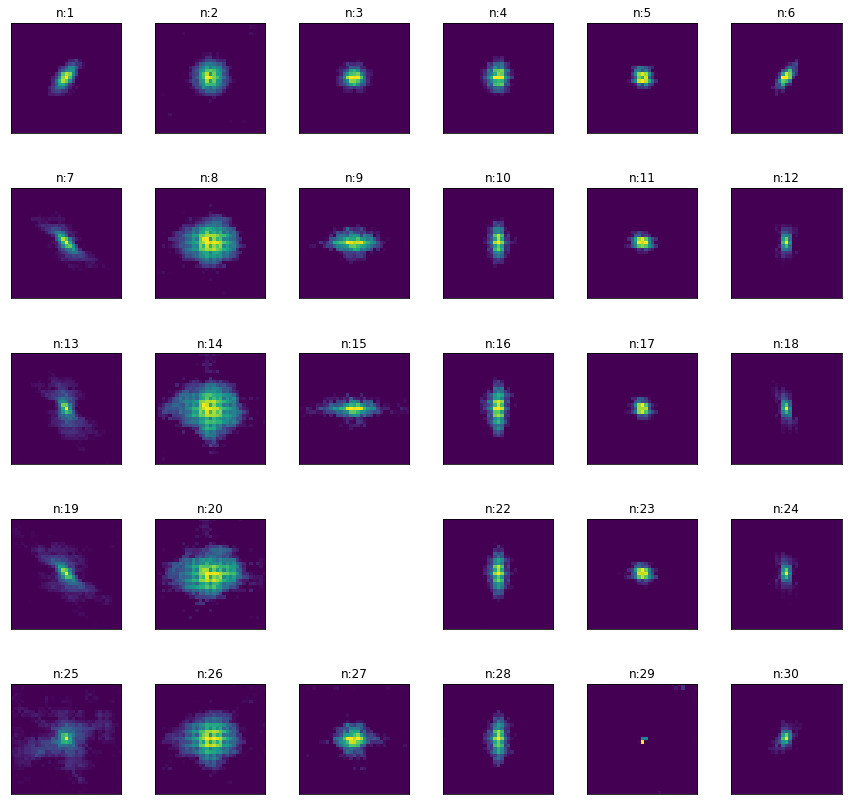

In [39]:
voltages = test_data[0].to(device)
distro_0 = test_data[1].to(device)
distro_1 = test_data[2].to(device)
distro_2 = test_data[3].to(device)
distro_3 = test_data[4].to(device)
distro_4 = test_data[5].to(device)
output_0 = test_targets[0].to(device)
output_1 = test_targets[1].to(device)
output_2 = test_targets[2].to(device)
output_3 = test_targets[3].to(device)
with torch.no_grad():
    distro, losses = model(voltages=voltages,
                           distro0=distro_0,
                           distro1=distro_1,
                           distro2=distro_2,
                           distro3=distro_3,
                           distro4=distro_4,
                           output0=output_0,
                           output1=output_1,
                           output2=output_2,
                           output3=output_3)
loss0 = nn.HuberLoss(reduction='mean', delta=10.0)(output_0, losses[0])
loss1 = nn.HuberLoss(reduction='mean', delta=10.0)(output_1, losses[1])
loss2 = nn.HuberLoss(reduction='mean', delta=10.0)(output_2, losses[2])
loss3 = nn.HuberLoss(reduction='mean', delta=10.0)(output_3, losses[3])
loss4 = nn.MSELoss()(distro_0, distro[0])
loss5 = nn.MSELoss()(distro_1, distro[1])
loss6 = nn.MSELoss()(distro_2, distro[2])
loss7 = nn.MSELoss()(distro_3, distro[3])
loss8 = nn.MSELoss()(distro_4, distro[4])
print(f"loss0:{loss0},loss1:{loss1}, loss2:{loss2}, loss3:{loss3},\n distro0:{loss4}, distro1:{loss5}, distro2:{loss6}, distro3:{loss7}, distro4:{loss8}")

fig = plt.figure(figsize=(12,12))
nimg = 2
for j in range(5):
    for i in range(6):
        plt.subplot(5,6,i+1+j*6)
        plt.tight_layout()
        plt.imshow(np.array(distro[j].cpu())[nimg,:,:,i], cmap='viridis', interpolation='none')
        plt.title(f"n:{i+1+j*6}")
        plt.xticks([])
        plt.yticks([])
fig.savefig(f"{main_dir}/ReconstructedPhaseSpace_{test_number}_3.png", dpi = 100)

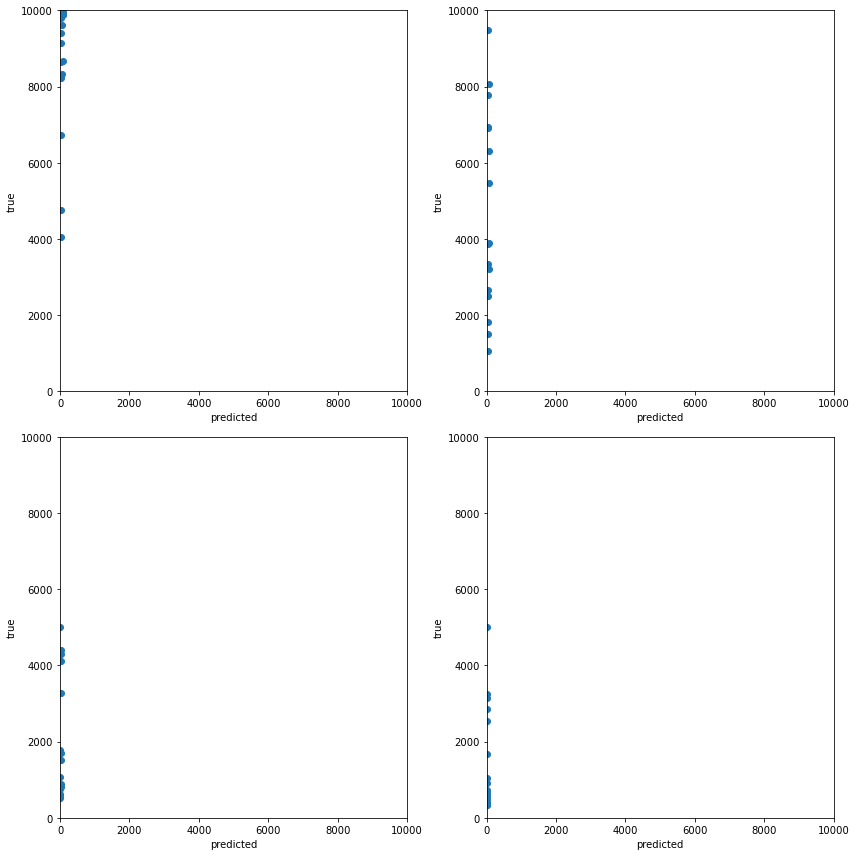

In [40]:
fig = plt.figure(figsize=(12,12))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.tight_layout()
    plt.scatter(losses[i].cpu(),test_targets[i])
    plt.xlabel('predicted')
    plt.ylabel('true')
    plt.xlim(0,10000)
    plt.ylim(0,10000)
fig.savefig(f"{main_dir}/Losses_{test_number}_3.png", dpi = 100)

In [41]:
torch.save(model.state_dict(), f"{main_dir}/model___{test_number}_3.pth")